# 04wk-2: (신경망) – 꺽인그래프의 한계(?), 시벤코정리, MNIST

최규빈  
2025-03-31

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/04wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-x0_7UUjYFf8ZDFCn2OQymk&si=UUZwyLdb6q89Lvle>

# 2. Imports

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

# 3. 꺽인그래프의 한계?

In [191]:
## 지난시간
# 목표: 꺽여있는 곡선을 만드는것 
# sig(꺽여있는직선)
#---#
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,2,bias=False), ## 두개의 직선 (기울기와 절편이 각각다른) 
#     torch.nn.ReLU(), # 두개의 ReLU직선 (relu: 양수는 그대로, 음수는 0으로)
#     torch.nn.Linear(2,1), # 하나의 꺽인직선 (두개를 하나로 합쳐서..) 
#     torch.nn.Sigmoid(), # 하나의 꺽이는곡선
# )
# (n,1) --l1--> (n,2) --a1--> (n,2) ---l2---> (n,1) ---a2---> (n,1)

`-` 걱정: 지난시간에 배운 기술은 sig를 취하기 전이 꺽은선인 형태만
가능할 듯 하다. 그래서 이 역시 표현력이 부족할 듯 하다.

`-` 그런데 생각보다 표현력이 풍부한 편이다. 즉 생각보다 쓸 만하다.

## A. Step은 표현 불가능하지 않나?

`# 예제1` – 일부러 이상하게 만든 취업합격률 곡선

In [8]:
torch.manual_seed(43052)
x = torch.linspace(-1,1,2000).reshape(-1,1)
u = 0*x-3
u[x<-0.2] = (15*x+6)[x<-0.2]
u[(-0.2<x)&(x<0.4)] = (0*x-1)[(-0.2<x)&(x<0.4)]
sig = torch.nn.Sigmoid()
v = π = sig(u)
y = torch.bernoulli(v)

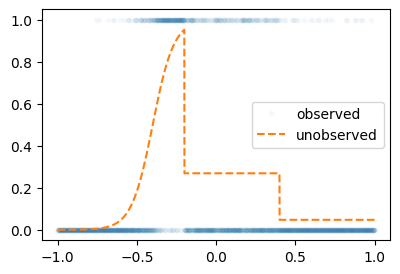

In [17]:
plt.plot(x,y,'.',alpha=0.03, label="observed")
plt.plot(x,v,'--', label="unobserved")
plt.legend()

In [18]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,512),
    torch.nn.ReLU(),
    torch.nn.Linear(512,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(5000):
    ## 1
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

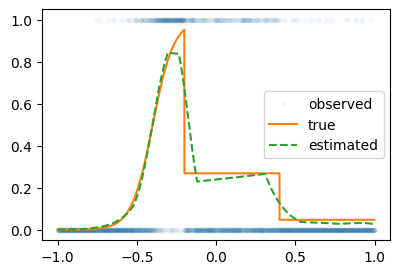

In [21]:
plt.plot(x,y,'.',alpha=0.03, label="observed")
plt.plot(x,v, label="true")
plt.plot(x,net(x).data,'--', label="estimated")
plt.legend()

`#`

## B. 곡선은 표현 불가능하지 않나?

`# 예제2` – 2024년 수능 미적30번 문제에 나온 곡선

$$y_i = e^{-x_i} \times  |\cos(5x_i)| \times \sin(5x) + \epsilon_i, \quad \epsilon_i \sim N(0,\sigma^2)$$

In [30]:
torch.manual_seed(43052)
x = torch.linspace(0,2,2000).reshape(-1,1)
eps = torch.randn(2000).reshape(-1,1)*0.05
fx = torch.exp(-1*x)* torch.abs(torch.cos(3*x))*(torch.sin(3*x))
y = fx + eps

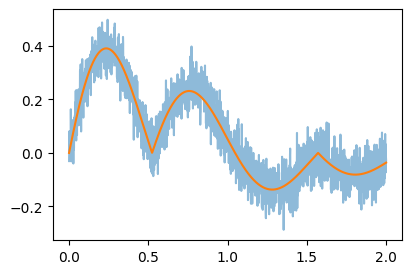

In [40]:
plt.plot(x,y,label="observed",alpha=0.5)
plt.plot(x,fx,label="true")

In [50]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,2048), # 꺽이지않은 1024개의 직선
    torch.nn.ReLU(), # 꺽인(렐루된) 1024개의 직선 
    torch.nn.Linear(2048,1), # 합쳐진 하나의 꺽인 직선 
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
## 
for epoc in range(1000):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

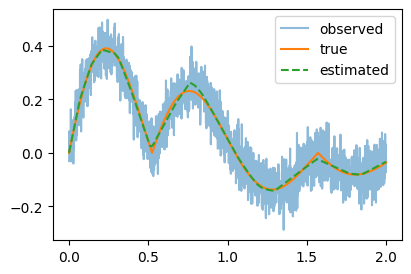

In [51]:
plt.plot(x,y,label="observed",alpha=0.5)
plt.plot(x,fx,label="true")
plt.plot(x,net(x).data,'--',label="estimated")
plt.legend()

`#`

# 4. 시벤코정리

## A. 시벤코정리 소개

> **Universal Approximation Thm (Cybenko 1989)**
>
> 하나의 은닉층을 가지는 아래와 같은 꼴의 네트워크
> $net: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$는
>
> ``` python
> net = torch.nn.Sequential(
>     torch.nn.Linear(p,???),
>     torch.nn.Sigmoid(),
>     torch.nn.Linear(???,q)
> )
> ```
>
> 모든 보렐 가측함수 (Borel measurable function)
>
> $$f: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$$
>
> 를 원하는 정확도로 “근사”시킬 수 있다. 쉽게 말하면
> ${\bf X} \to {\bf y}$ 인 어떠한 복잡한 규칙라도 하나의 은닉층을 가진
> 신경망이 원하는 정확도로 근사시킨다는 의미이다. 예를들면 아래와 같은
> 문제를 해결할 수 있다.
>
> -   ${\bf X}_{n\times 2}$는 토익점수, GPA 이고 ${\bf y}_{n\times 1}$는
>     취업여부일 경우 ${\bf X} \to {\bf y}$인 규칙을 신경망은 항상 찾을
>     수 있다.
> -   ${\bf X}_{n \times p}$는 주택이미지, 지역정보, 주택면적, 주택에
>     대한 설명 이고 ${\bf y}_{n\times 1}$는 주택가격일 경우
>     ${\bf X} \to {\bf y}$인 규칙을 신경망은 항상 찾을 수 있다.
>
> 즉 하나의 은닉층을 가진 신경망의 표현력은 거의 무한대라 볼 수 있다.

> 보렐가측함수에 대한 정의는 측도론에 대한 이해가 있어야 가능함.
> 측도론에 대한 내용이 궁금하다면 <https://guebin.github.io/SS2024/> 을
> 공부해보세요

## B. 시벤코정리의 증명 (스케치만..)

`-` 준비

In [63]:
x = torch.linspace(-10,10,200).reshape(-1,1)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2),
    torch.nn.Sigmoid(),
    torch.nn.Linear(in_features=2,out_features=1)
)
l1,a1,l2 = net

In [65]:
net

`# 생각1` – 2개의 시그모이드를 우연히 잘 조합하면 하나의 계단함수를 만들
수 있다.

In [66]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+10.00,+10.00])

In [67]:
l2.weight.data = torch.tensor([[1.00,1.00]])
l2.bias.data = torch.tensor([-1.00])

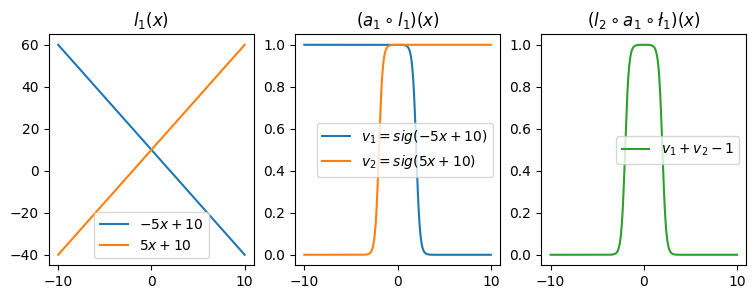

In [69]:
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,l1(x)[:,[0]].data,label=r"$-5x+10$")
ax[0].plot(x,l1(x)[:,[1]].data,label=r"$5x+10$")
ax[0].set_title('$l_1(x)$')
ax[0].legend()
ax[1].plot(x,a1(l1(x))[:,[0]].data,label=r"$v_1=sig(-5x+10)$")
ax[1].plot(x,a1(l1(x))[:,[1]].data,label=r"$v_2=sig(5x+10)$")
ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[1].legend()
ax[2].plot(x,l2(a1(l1(x))).data,color='C2',label=r"$v_1+v_2-1$")
ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$')
ax[2].legend()

`#`

`# 생각2` – 계단함수의 모양이 꼭 생각1과 같을 필요는 없다. 중심은
이동가능하고, 높이도 조절가능하다.

**가능한 예시1**

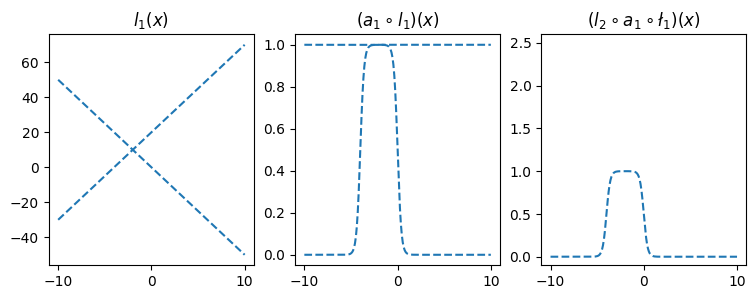

In [70]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+0.00,+20.00])
l2.weight.data = torch.tensor([[1.00,1.00]])
l2.bias.data = torch.tensor([-1.00])
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,l1(x).data.numpy(),'--',color='C0'); ax[0].set_title('$l_1(x)$')
ax[1].plot(x,a1(l1(x)).data.numpy(),'--',color='C0'); ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[2].plot(x,l2(a1(l1(x))).data,'--',color='C0'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$');
ax[2].set_ylim(-0.1,2.6)

**가능한 예시2**

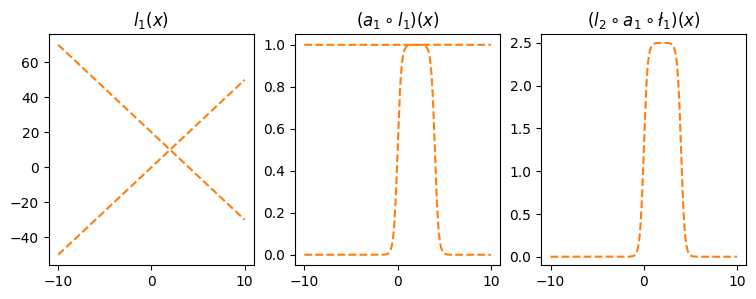

In [71]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+20.00,+00.00])
l2.weight.data = torch.tensor([[2.50,2.50]])
l2.bias.data = torch.tensor([-2.50])
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,l1(x).data.numpy(),'--',color='C1'); ax[0].set_title('$l_1(x)$')
ax[1].plot(x,a1(l1(x)).data.numpy(),'--',color='C1'); ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[2].plot(x,l2(a1(l1(x))).data,'--',color='C1'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$');
ax[2].set_ylim(-0.1,2.6)

`#`

`# 생각3`: 첫번째 선형변환(=$l_1$)에서 `out_features=4`로 하고 적당한
가중치를 조정하면 $(l_2\circ a_1 \circ l_1)(x)$의 결과로 생각2의
예시1,2를 조합한 형태도 가능할 것 같다. 즉 4개의 시그모이드를 잘
조합하면 2단계 계단함수를 만들 수 있다.

In [80]:
l1 = torch.nn.Linear(in_features=1,out_features=4)
a1 = torch.nn.Sigmoid()
l2 = torch.nn.Linear(in_features=4,out_features=1)

In [81]:
l1.weight.data = torch.tensor([[-5.00],[5.00],[-5.00],[5.00]])
l1.bias.data = torch.tensor([0.00, 20.00, 20.00, 0])
l2.weight.data = torch.tensor([[1.00,  1.00, 2.50,  2.50]])
l2.bias.data = torch.tensor([-1.0-2.5])

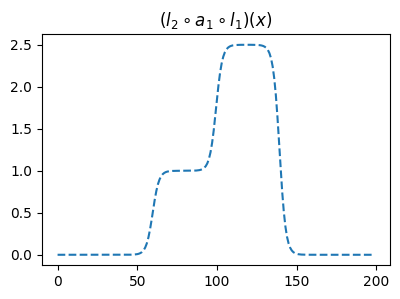

In [82]:
plt.plot(l2(a1(l1(x))).data,'--')
plt.title(r"$(l_2 \circ a_1 \circ l_1)(x)$")

> 이러한 함수는 계단모양이며, 0을 제외한 서로다른 계단의 높이는 2개가
> 된다. 이를 간단히 “2단계-계단함수”라고 칭하자.

`#`

`# 생각4` – $2m$개의 시그모이드를 우연히 잘 조합하면 $m$단계 계단함수를
만들 수 있다.

`-` 정리1: 2개의 시그모이드를 우연히 잘 결합하면 아래와 같은
“1단계-계단함수” 함수 $h$를 만들 수 있다.

In [100]:
def h(x):
    sig = torch.nn.Sigmoid()
    v1 = -sig(200*(x-0.5))
    v2 = sig(200*(x+0.5))
    return v1+v2 

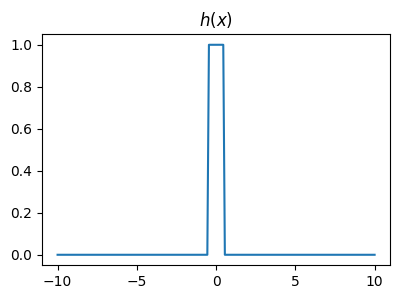

In [101]:
plt.plot(x,h(x))
plt.title("$h(x)$")

`-` 정리2: 위와 같은 함수 $h$를 이용한 아래의 네트워크를 고려하자. 이는
“m단계-계단함수”를 만든다.

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$$

그리고 위의 네트워크와 동일한 효과를 주는 아래의 네트워크가 항상 존재함.

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2m)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,2m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$$

`#`

`# 생각5` – 그런데 어지간한 함수형태는 구불구불한 “m단계-계단함수”로 다
근사할 수 있지 않나?

그렇다면 아래의 네트워크에서 (1) ?? 를 충분히 키우고 (2) 적절하게 학습만
잘 된다면

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(p,???),
    torch.nn.Sigmoid(),
    torch.nn.Linear(???,q)
)
```

위의 네트워크는 거의 무한한 표현력을 가진다. –\> 이런식으로 증명하면
됩니당

`#`

## C. $h$의 위력

`-` 소망: 아래와 같이 `net`을 설계해서, 그 위력을 체감해보고 싶은데..

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(1,??),
    torch.nn.H(),
    torch.nn.Linear(??,1)
)
```

`-` $h(x)$를 생성하는 클래스를 만들어보자.

In [109]:
class H(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        def h(x):
            sig = torch.nn.Sigmoid()
            v1 = -sig(200*(x-0.5))
            v2 = sig(200*(x+0.5))
            return v1+v2 
        out = h(x)
        return out 

In [110]:
h = H()

`-` $h$의 위력을 체감해보자.

`# 예제1` – 스펙의 역설

In [111]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2025/main/posts/ironyofspec.csv")
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)
prob = torch.tensor(df.prob).float().reshape(-1,1)

In [116]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,2048),
    H(),
    torch.nn.Linear(2048,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(200):
    ## 1 
    yhat = net(x)
    ## 2
    loss = loss_fn(yhat,y)
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

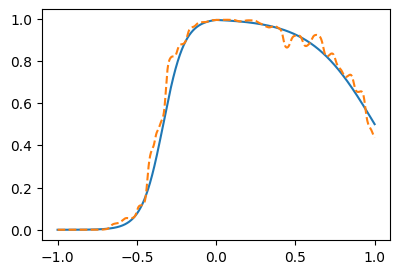

In [117]:
plt.plot(x,prob)
plt.plot(x,net(x).data,'--')

`#`

`# 예제2` – 수능곡선

In [118]:
torch.manual_seed(43052)
x = torch.linspace(0,2,2000).reshape(-1,1)
eps = torch.randn(2000).reshape(-1,1)*0.05
fx = torch.exp(-1*x)* torch.abs(torch.cos(3*x))*(torch.sin(3*x))
y = fx + eps

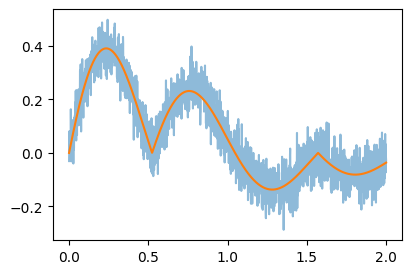

In [121]:
plt.plot(x,y,alpha=0.5)
plt.plot(x,fx)

In [122]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,2048),
    H(),
    torch.nn.Linear(2048,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(200):
    ## 1 
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()


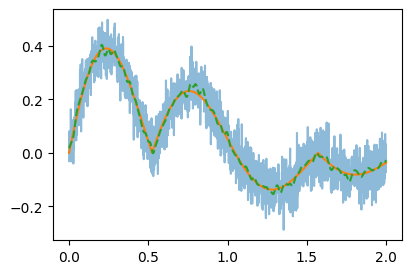

In [125]:
plt.plot(x,y,alpha=0.5)
plt.plot(x,fx)
plt.plot(x,net(x).data,'--')

`#`

## D. 의문점

`-` 이 수업을 잘 이해한 사람: 그냥 활성화함수를 $h$로 쓰면 끝 아니야?
뭐하러 relu 를 쓰는거지?

`-` 딥러닝을 좀 공부해본사람1: 왜 딥러닝이 2010년이 지나서야 떳지?
1989년에 세상의 모든 문제가 풀려야 하는것 아닌가?

`-` 딥러닝을 좀 공부해본사람2: 하나의 은닉층을 가진 네크워크는 잘 안쓰지
않나? 은닉층이 깊을수록 좋다고 들었는데?

`-` 약간의 의구심이 있지만 아무튼 우리는 아래의 무기를 가진 꼴이 되었다.

> **우리의 무기**
>
> 하나의 은닉층을 가지는 아래와 같은 꼴의 네트워크로,
>
> ``` python
> net = torch.nn.Sequential(
>     torch.nn.Linear(p,???),
>     torch.nn.Sigmoid(),
>     torch.nn.Linear(???,q)
> )
> ```
>
> $f: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$ 인 모든 보렐 가측
> 함수 $f$ 을 원하는 정확도로 “근사”시킬 수 있다.

# 5. MNIST 해결

## A. 예비학습 – `plt.imshow()`

`-` `plt.imshow(..., cmap="gray")` 에서 `...`이 shape이 (??,??)이면
흑백이미지를 출력

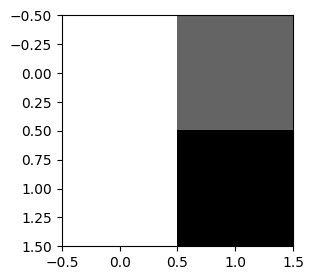

In [131]:
img = torch.tensor([[255,100],
                    [255,0]])
plt.imshow(img,cmap="gray")

`-` `plt.imshow(...)` 에서 `...`의 shape이 (??,??,3)이면 칼라이미지를
출력

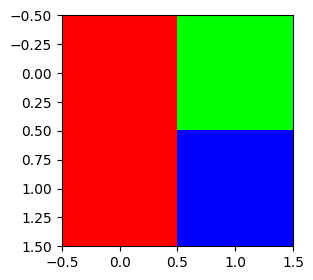

In [148]:
r = torch.tensor([[255,0],
                  [255,0]])
g = torch.tensor([[0,255],
                  [0,0]])
b = torch.tensor([[0,0],
                  [0,255]])
img = torch.stack([r,g,b],axis=-1)
plt.imshow(img)

`-` `plt.imshow(...)` 에서 `...`의 자료형이 int인지 float인지에 따라서
인식이 다름

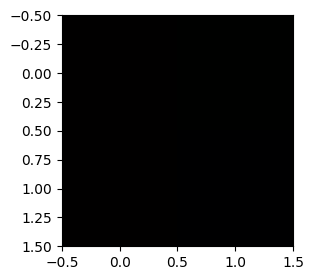

In [151]:
r = torch.tensor([[1,0],
                  [1,0]])
g = torch.tensor([[0,1],
                  [0,0]])
b = torch.tensor([[0,0],
                  [0,1]])
img = torch.stack([r,g,b],axis=-1)
plt.imshow(img)

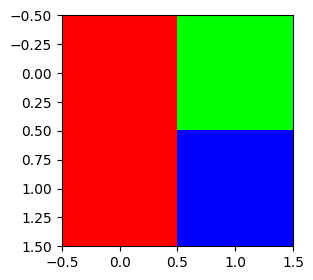

In [155]:
r = torch.tensor([[255,0],
                  [255,0]])/255
g = torch.tensor([[0,255],
                  [0,0]])/255
b = torch.tensor([[0,0],
                  [0,255]])/255
img = torch.stack([r,g,b],axis=-1)
plt.imshow(img)

## B. 데이터

`-` 데이터 정리코드

In [246]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
to_tensor = torchvision.transforms.ToTensor()
X3 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==3])
X7 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==7])
X = torch.concat([X3,X7],axis=0)
y = torch.tensor([0.0]*len(X3) + [1.0]*len(X7))

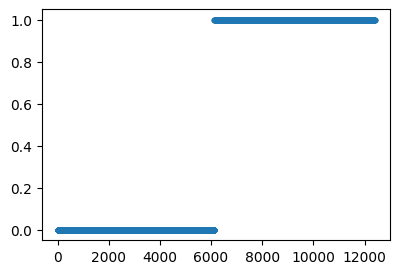

In [173]:
plt.plot(y,'.')

`-` 우리는 ${\bf X}: (n,1,28,28)$ 에서 ${\bf y}: (n,1)$으로 가는 맵핑을
배우고 싶음. $\to$ 이런건 배운적이 없는데?.. $\to$ 그렇다면
${\bf X}:(n,784) \to {\bf y}:(n,1)$ 으로 가는 맵핑을 학습하자.

In [187]:
X = torch.stack([img.reshape(-1) for img in X])
y = y.reshape(-1,1)

In [189]:
X.shape,y.shape

## C. 학습

In [221]:
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(200):
    ## 1 
    yhat = net(X) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

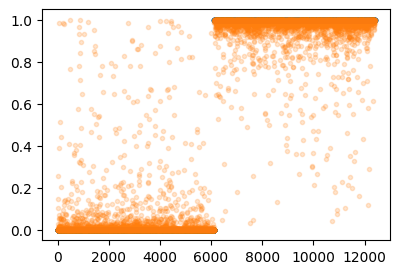

In [222]:
plt.plot(y,'.')
plt.plot(net(X).data,'.',alpha=0.2)

In [223]:
((y == (net(X).data > 0.5))*1.0).mean()

Cybenko, George. 1989. “Approximation by Superpositions of a Sigmoidal
Function.” *Mathematics of Control, Signals and Systems* 2 (4): 303–14.